In [1]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent.futures
import urllib.request
import os
import shutil
import csv

# Threat data

In [2]:
# dataset present in site https://data.world/crowdflower/image-sentiment-polarity/workspace/file?filename=image-Sentiment-polarity-DFE.csv
dataframe = pd.read_csv('image-Sentiment-polarity-DFE.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15613 entries, 0 to 15612
Data columns (total 10 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   _unit_id                                                                        15613 non-null  int64  
 1   _golden                                                                         15613 non-null  bool   
 2   _unit_state                                                                     15613 non-null  object 
 3   _trusted_judgments                                                              15613 non-null  int64  
 4   _last_judgment_at                                                               14999 non-null  object 
 5   which_of_these_sentiment_scores_does_the_above_image_fit_into_best              15613 non-null  object 
 6   which_of_these

In [3]:
dataframe

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,which_of_these_sentiment_scores_does_the_above_image_fit_into_best,which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence,imageurl,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason
0,694550568,True,golden,47,NaN,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,Highly positive\nPositive,"He is smiling. => happy, joy"
1,694550569,True,golden,36,NaN,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,Highly positive\nPositive,A beautiful scenery. => serenity
2,694550570,True,golden,35,NaN,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,Negative\nHighly negative,"They look serious. => sadness, fear"
3,694550571,True,golden,41,NaN,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,Highly positive\nPositive,"A cute puppy. => happy, joy"
4,694550572,True,golden,46,NaN,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,Highly positive\nPositive,"She looks fun. => fun, joy, happy"
...,...,...,...,...,...,...,...,...,...,...
15608,694566363,False,finalized,3,3/26/15 1:59,Positive,0.6705,http://farm3.static.flickr.com/2198/1572103607...,NaN,NaN
15609,694566364,False,finalized,3,3/26/15 2:13,Positive,0.3373,http://farm1.static.flickr.com/100/263134442_6...,NaN,NaN
15610,694566365,False,finalized,3,3/26/15 2:54,Positive,0.6663,http://farm2.static.flickr.com/1360/1392747419...,NaN,NaN
15611,694566366,False,finalized,3,3/26/15 2:46,Negative,0.6760,http://farm3.static.flickr.com/2077/1925076121...,NaN,NaN


<AxesSubplot:>

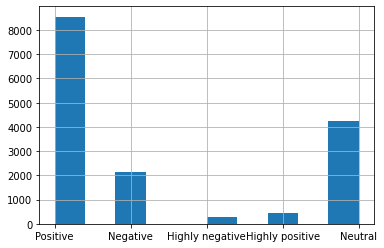

In [4]:
# histogram of positive and negative images
dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].hist()

In [7]:
sentimental_label_classify = dataframe[
    'which_of_these_sentiment_scores_does_the_above_image_fit_into_best'
]

In [8]:
sentimental_label_classify.unique()

array(['Positive', 'Negative', 'Highly negative', 'Highly positive',
       'Neutral'], dtype=object)

In [9]:
def plot_pie_chart_count_sentiments(sentiment_count):
    fig1, ax1 = plt.subplots()
    ax1.pie(
        sentiment_count.values(), 
        labels=list(sentiment_count.keys()), 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90
    )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Distribution classify labels 

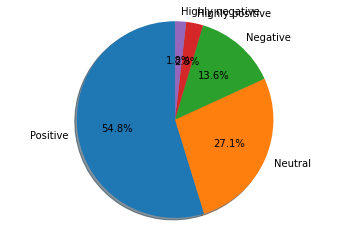

In [10]:
sentiment_count = dict(sentimental_label_classify.value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [11]:
dataframe['sentiment'] = dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']
dataframe['sentiment'].replace({"Highly negative": "Negative", "Highly positive": "Positive"}, inplace=True)

In [12]:
dataframe['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

### Distribution after eliminate classify labels 

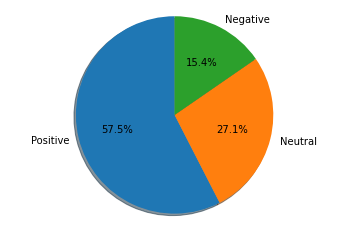

In [13]:
sentiment_count = dict(dataframe['sentiment'].value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [24]:
X = dataframe['imageurl']
y = dataframe['sentiment']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=100)
# print(f"Training target statistics: {Counter(y_train)}")
# print(f"Testing target statistics: {Counter(y_test)}")

### Download dataset image

In [63]:
images_not_found = []
# create main directory
DATASET_MAIN_DIRECTORY = "dataset"
if not os.path.exists(DATASET_MAIN_DIRECTORY):
    os.makedirs(DATASET_MAIN_DIRECTORY)

# create label directories
for label in y.unique():
    if not os.path.exists(f"{DATASET_MAIN_DIRECTORY}/{label}"):
        os.makedirs(
            f"{DATASET_MAIN_DIRECTORY}/{label}"
        )

def download_image(kwargs):
    filename = kwargs['image_url'].split("/")[-1]
    try:
        urllib.request.urlretrieve(
            kwargs['image_url'], 
            f"{DATASET_MAIN_DIRECTORY}/{kwargs['label']}/{filename}"
        )
    except urllib.error.HTTPError:
        print(f"Not Found: {url}")
        images_not_found.append(url)
        
with concurrent.futures.ThreadPoolExecutor() as executor:
    #download images to directories
    for image_url, label_classified in zip(X, y):
        executor.submit(
            download_image, 
            {
                'image_url': image_url, 
                'label': label_classified
            }
    )        
    
with open('images_not_found.txt', 'w') as f:
    f.writelines(images_not_found)

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://far

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

## Threat dataset from "http://www.t4sa.it/"

In [2]:
os.listdir("../b-t4sa_imgs")

['b-t4sa_test.txt',
 'data',
 'b-t4sa_train.txt',
 'b-t4sa_val.txt',
 'b-t4sa_all.txt']

In [3]:
labels = os.listdir("./dataset")

In [ ]:
label = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}

files = {
    "Negative": [],
    "Neutral": [],
    "Positive": []
}

with open('../b-t4sa_imgs/b-t4sa_all.txt') as f:
    lines = f.readlines()
    for line in lines:
        [path_img, classify] = line.replace("\n", "").split(" ")
        filename = path_img.split("/")[-1]
        shutil.move('../b-t4sa_imgs/' + path_img, f'./dataset/{label[classify]}/{filename}')
        files[label[classify]].append(filename)

In [ ]:
with open('image_dataset.csv', mode='w') as csv_file:
    fieldnames = ['filename', 'classifying']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for key in list(files.keys()):
        for file in files[key]:
            writer.writerow(
                {
                    'filename': file, 
                    'classifying': key,
                }
            )

## Get all the merge data from dataset

In [4]:
labels

['Positive', 'Negative', 'Neutral']

In [7]:
final_dataset = []
with open('final_image_dataset.csv', mode='w') as csv_file:
    fieldnames = ['filename', 'classifying']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    for label in labels:
        for file in os.listdir(f'./dataset/{label}'):
            writer.writerow(
                {
                    'filename': file, 
                    'classifying': label,
                }
            )

## Balancing the dataset

In [25]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X.values.reshape(-1, 1), y)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, 
    y_res, 
    test_size=0.15, 
    random_state=100
)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'Negative': 2049, 'Neutral': 2048, 'Positive': 2028})
Testing target statistics: Counter({'Positive': 374, 'Neutral': 354, 'Negative': 353})


Text(0.5, 1.0, 'Número de dados no dataset')

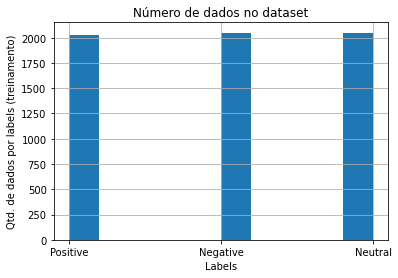

In [30]:
y_train.hist()
plt.ylabel('Qtd. de dados por labels (treinamento)')
plt.xlabel('Labels')
plt.title('Número de dados no dataset')

Text(0.5, 1.0, 'Número de dados no dataset')

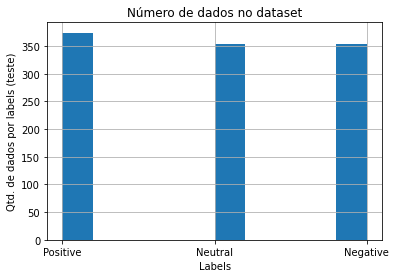

In [31]:
y_test.hist()
plt.ylabel('Qtd. de dados por labels (teste)')
plt.xlabel('Labels')
plt.title('Número de dados no dataset')